# Lindbald equation for two level coupled atom, undergoing spontaneous emission

### Problem
The master equation is given by :

$$
\frac{d ρ(t) }{dt} = -(i/h) [H,ρ] + γ[ 2(σ-​ρσ+) - { σ+​σ−​,ρ }]
$$

where:  

- $H$ is an Hamiltonian H = -(ℏω/2)​Z ; Z is pauli Z gate
- L= $\sqrt{γ}$σ− ​= $\sqrt{γ}$ ∣0⟩⟨1∣

**Contributor:** Daksh Sambhare [QIntern Mentee]


In [16]:
from qutip import *
import numpy as np

t= 5.0
gamma = 2.0           # Decay rate
# for hamiltonian energy spliting
omega = 1.0          

sm = destroy(2)                   # σ-
sp = sm.dag()                     # σ+
Z = sigmaz()                      # Pauli Z
H = -0.5 * omega * Z            # Hamiltonian for the coherent part as given
# Initial state: p(0)
# we apply Lp(0) to get dp(t)/ dt
# Liouvillian superoperator function, I found this on Qutip documentation**
# what it does is convert Lindblad operators in master equation to its superoperator form
c_ops = [np.sqrt(gamma) * sm]
L1 = liouvillian(H, c_ops)
superprop = (t * L1).expm()
L1 = L1.full()

print("Liouvillian superoperator:", superprop)   


Liouvillian superoperator: Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          9.99954600e-01+0.j        ]
 [ 0.00000000e+00+0.j          1.91130077e-03+0.00646118j
  -0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   1.91130077e-03-0.00646118j  0.00000000e+00-0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          4.53999298e-05+0.j        ]]


## The master equation is converted to form
  $$  \frac{d vec(ρ(t)) }{dt} =Lmatrix⋅vec(ρ) $$



- I need to convert the Lindblad to a luvillion form, that will lead to exponentiation linear map , Superoperator Mapping
- Now, I can apply choi matrice formalism, So that it can be decomposed to kraus operator

In [17]:
import numpy as np
from numpy.linalg import eig
from qutip import Qobj

def super_to_choi(q_oper: Qobj) -> (Qobj, int, int):
# Extract raw array and dims
    data = q_oper.full()
    dims = q_oper.dims  
    d0 = dims[0][0][0] 
    d1 = dims[1][0][0] 
    # Build the Choi array 
    choi_arr = (
        data.reshape((d0, d1, d0, d1))
            .transpose(3, 1, 2, 0)
            .reshape((d0*d1, d0*d1))
    )

    choi = Qobj(choi_arr,
                dims=[[ [d1], [d0] ],   # row dims = [d_out, d_in]
                      [ [d1], [d0] ]],  # col dims = same for a square 4×4 matrix
                superrep='choi')
    return choi, d0, d1


def choi_to_kraus(choi: Qobj, d0: int, d1: int, tol: float = 1e-9) -> list[Qobj]:
    # Eigen decomposition of the Choi matrix
    vals, vecs = eig(choi.full())
    kraus_ops = []
    for val, vec in zip(vals, vecs.T):
        if val > tol:
            mat = vec.reshape((d1, d0), order='F')
           
            K = Qobj(np.sqrt(val) * mat,
                     dims=[[d1], [d0]])
            kraus_ops.append(K)
    return kraus_ops


def super_to_kraus(q_oper: Qobj, tol: float = 1e-9) -> list[Qobj]:

    choi, d0, d1 = super_to_choi(q_oper)
    return choi_to_kraus(choi, d0, d1, tol)


kraus_ops = super_to_kraus(superprop)

# for i, k in enumerate(kraus_ops):
#     print(f"Kraus operator {i}:\n{k}")

K0 = kraus_ops[0]
K1 = kraus_ops[1]
K0= np.real(K0.full())
K1 = np.real(K1.full())
print("Kraus Operators- \n ","First :\n", K0 ,"\n Second : \n" , K1)

Kraus Operators- 
  First :
 [[1.        0.       ]
 [0.        0.0019113]] 
 Second : 
 [[0.        0.9999773]
 [0.        0.       ]]


## After getting Kraus operators from Choi Form, Below we perform SVD 




Quantum Simulation result :
 [[0.99995-0.j 0.     +0.j]
 [0.     +0.j 0.     +0.j]]


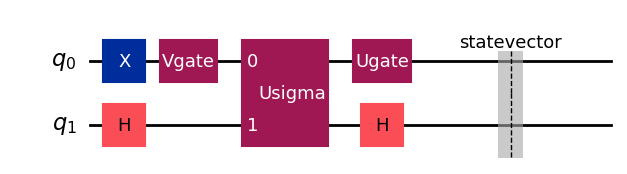

In [18]:
# Define Kraus Operators
import numpy as np
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd
from scipy.linalg import expm


##############################################
#SVD and walsh  
def SVD(Kraus_op):
    
    U_1, sigma_1, V_dagger = svd(Kraus_op)
    
    sigma_vals1 = sigma_1
    sigma1 = np.diag(sigma_1)
    f_k1 = np.zeros(4)
    for i, sigma_val in enumerate(sigma_vals1):
        val = float(np.clip(sigma_val, -1, 1))
        f_k1[i] = np.arccos(val)
        f_k1[i+2] = -np.arccos(val)
    # print(f_k1)
    W1 = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1], 
              [1, 1, -1, -1],
              [1, -1, -1, 1]])
    a1 = (W1 @ f_k1) / 4
    U_sigma = np.diag(np.exp(1j * np.array(f_k1)))
    # L = (U_1 @ sigma1 @ V_dagger)
    return U_1 , U_sigma , V_dagger

#############################################################
def Quantum_circuit(U, sigma,V):
    qc = QuantumCircuit(2)
    qc.x(0)

    V = UnitaryGate(V, label="Vgate")
    qc.append(V, [0])

    qc.h(1)

    U_sigma_gate = UnitaryGate(sigma, label="Usigma")
    qc.append(U_sigma_gate, [0, 1])

 
    U = UnitaryGate(U, label="Ugate")
    qc.append(U, [0])
    qc.h(1)

    qc.save_statevector()
    
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc,shots=1024, memory=True).result()
    statevector = result.get_statevector(qc)

    final_state =[]
    for i in range(2):
        final_state.append(statevector[i])

    final_state = np.array(final_state)
    rho00_t = np.outer(final_state, np.conj(final_state))
    # print("State vector:\n", np.round(rho0_t,8))

    return rho00_t, qc
###########################################
U1 , sigma1 , V1 = SVD(K1)
U2 , sigma2 , V2 = SVD(K0)
###########################################


rho_0T,qc  = Quantum_circuit(U1,sigma1, V1)
rho_1T, qc  = Quantum_circuit(U2,sigma2, V2)
print("\n\nQuantum Simulation result :\n",np.round(( rho_0T + rho_1T),5))
qc.draw('mpl')


## Comparision of Kraus Operators for SVD with the pre-computed results.


In [19]:
# Define Kraus Operators
import numpy as np
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd
from scipy.linalg import expm


##############################################
#SVD and walsh  
def SVD(Kraus_op):
    
    U_1, sigma_1, V_dagger = svd(Kraus_op)
    
    sigma_vals1 = sigma_1
    sigma1 = np.diag(sigma_1)
    f_k1 = np.zeros(4)
    for i, sigma_val in enumerate(sigma_vals1):
        val = float(np.clip(sigma_val, -1, 1))
        f_k1[i] = np.arccos(val)
        f_k1[i+2] = -np.arccos(val)
    # print(f_k1)
    W1 = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1], 
              [1, 1, -1, -1],
              [1, -1, -1, 1]])
    a1 = (W1 @ f_k1) / 4
    U_sigma = np.diag(np.exp(1j * np.array(f_k1)))
    # L = (U_1 @ sigma1 @ V_dagger)
    return U_1 , U_sigma , V_dagger

#############################################################
def Quantum_circuit(U, sigma,V):
    qc = QuantumCircuit(2)
    qc.x(0)

    V = UnitaryGate(V, label="Vgate")
    qc.append(V, [0])

    qc.h(1)

    U_sigma_gate = UnitaryGate(sigma, label="Usigma")
    qc.append(U_sigma_gate, [0, 1])

 
    U = UnitaryGate(U, label="Ugate")
    qc.append(U, [0])
    qc.h(1)

    qc.save_statevector()
    
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc,  shots=1024, memory=True).result()
    statevector = result.get_statevector(qc)
    # print("State vector:\n", statevector)   
    final_state =[]
    for i in range(2):
        final_state.append(statevector[i])

    final_state = np.array(final_state)
    rho0_t = np.outer(final_state, np.conj(final_state))
    # print("State vector:\n", np.round(rho0_t,8))
    qc.draw('mpl')
    return rho0_t
##############################################################
def kraus_ops_(t):
    lambda_t = 1 - np.exp((-gamma*t))
    K0 = np.array([[1, 0], [0, np.sqrt(1 - lambda_t)]])
    K1 = np.array([[0, np.sqrt(lambda_t)], [0, 0]])
    return K0, K1
gamma = 0.5
t=1.4
K0 , K1 = kraus_ops_(t)
rho = np. array([[0,0],[0,1]]) # state rho(0) = |1> <1|

rho_t = (K0 @ rho @ K0.conj().T ) + (K1 @ rho @ K1.conj().T)
print(f"Initial state ", rho)
print(f"Final analytical state: ")
print(rho_t)

############################################
U1 , sigma1 , V1 = SVD(K1)
U2 , sigma2 , V2 = SVD(K0)

rho_0T = Quantum_circuit(U1,sigma1, V1)
rho_1T = Quantum_circuit(U2,sigma2, V2)
print("Quantum Simulation result :\n", np.real(( rho_0T + rho_1T)))


Initial state  [[0 0]
 [0 1]]
Final analytical state: 
[[0.5034147 0.       ]
 [0.        0.4965853]]
Quantum Simulation result :
 [[0.5034147 0.       ]
 [0.        0.4965853]]


# Fidelity of Analytical vs Quantum Circuit

Initial state  [[0 0]
 [0 1]]


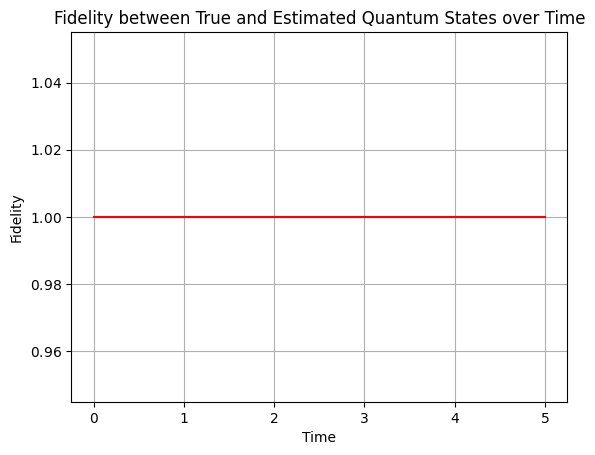

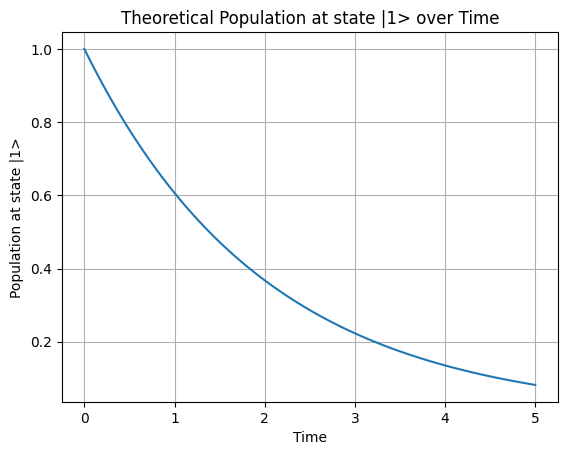

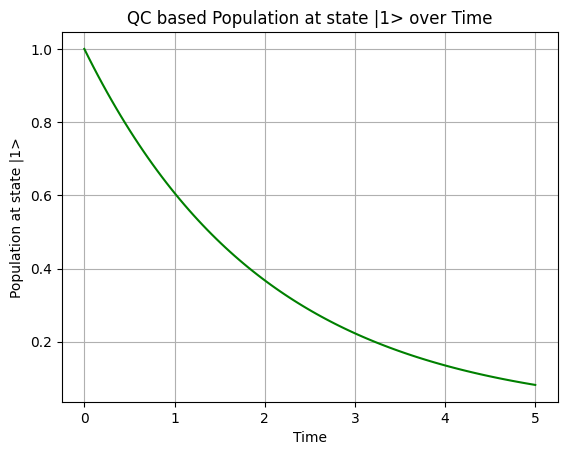

In [20]:
# Define Kraus Operators
import numpy as np
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

##############################################
#SVD and walsh  
def SVD(Kraus_op):
    
    U_1, sigma_1, V_dagger = svd(Kraus_op)
    
    sigma_vals1 = sigma_1
    sigma1 = np.diag(sigma_1)
    f_k1 = np.zeros(4)
    for i, sigma_val in enumerate(sigma_vals1):
        val = float(np.clip(sigma_val, -1, 1))
        f_k1[i] = np.arccos(val)
        f_k1[i+2] = -np.arccos(val)
    # print(f_k1)
    W1 = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1], 
              [1, 1, -1, -1],
              [1, -1, -1, 1]])
    a1 = (W1 @ f_k1) / 4
    U_sigma = np.diag(np.exp(1j * np.array(f_k1)))
    # L = (U_1 @ sigma1 @ V_dagger)
    return U_1 , U_sigma , V_dagger

#############################################################
def Quantum_circuit(U, sigma,V):
    qc = QuantumCircuit(2)
    qc.x(0)

    V = UnitaryGate(V, label="Vgate")
    qc.append(V, [0])

    qc.h(1)

    U_sigma_gate = UnitaryGate(sigma, label="Usigma")
    qc.append(U_sigma_gate, [0, 1])

 
    U = UnitaryGate(U, label="Ugate")
    qc.append(U, [0])
    qc.h(1)

    qc.save_statevector()
    
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc, shots=1024, memory=True).result()
    statevector = result.get_statevector(qc)

    final_state =[]
    for i in range(2):
        final_state.append(statevector[i])

    final_state = np.array(final_state)
    rho0_t = np.outer(final_state, np.conj(final_state))
    # print("State vector:\n", np.round(rho0_t,8))
    qc.draw('mpl')
    return rho0_t
##############################################################
def kraus_ops_(t):
    gamma = 0.5
    lambda_t = 1 - np.exp((-gamma*t))
    K0 = np.array([[1, 0], [0, np.sqrt(1 - lambda_t)]])
    K1 = np.array([[0, np.sqrt(lambda_t)], [0, 0]])
    return K0, K1
############################################################


def fidelity(rho, sigma):
    sqrt_rho = np.sqrt(rho)
    inner_term = np.sqrt(sqrt_rho @ sigma @ sqrt_rho)
    return np.real(np.trace(inner_term))**2

fidelity_ = []
population_t = []
population_Qc = []
time = np.linspace(0, 5, 100) # Time from 0 to 5 with 100 points

############################################################
rho = np. array([[0,0],[0,1]]) # state rho(0) = |1> <1|
print(f"Initial state ", rho)
for t in time:
   K0 , K1 = kraus_ops_(t)
   rho_t = (K0 @ rho @ K0.conj().T ) + (K1 @ rho @ K1.conj().T)
   U1 , sigma1 , V1 = SVD(K1)
   U2 , sigma2 , V2 = SVD(K0)
   rho_0T = Quantum_circuit(U1,sigma1, V1)
   rho_1T = Quantum_circuit(U2,sigma2, V2)
   rho_f =  rho_0T + rho_1T
   population_t.append(np.trace(rho_t @ rho))
   population_Qc.append(np.trace( rho_f @ rho))
   fidelity_value = fidelity(np.round(rho_t), np.round(rho_f))
   fidelity_.append(fidelity_value)
############################################




plt.plot(time, fidelity_, c='red')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity between True and Estimated Quantum States over Time")
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=False)
ax.yaxis.get_offset_text().set_visible(False)
plt.show()
plt.plot(time, population_t)
plt.xlabel("Time")
plt.ylabel("Population at state |1>")
plt.title("Theoretical Population at state |1> over Time")
plt.grid(True)
plt.show()
plt.plot(time, np.real(population_Qc),c='green')
plt.xlabel("Time")
plt.ylabel("Population at state |1>")
plt.title("QC based Population at state |1> over Time")
plt.grid(True)
plt.show()


## Expectation values of Pauli Gates over time

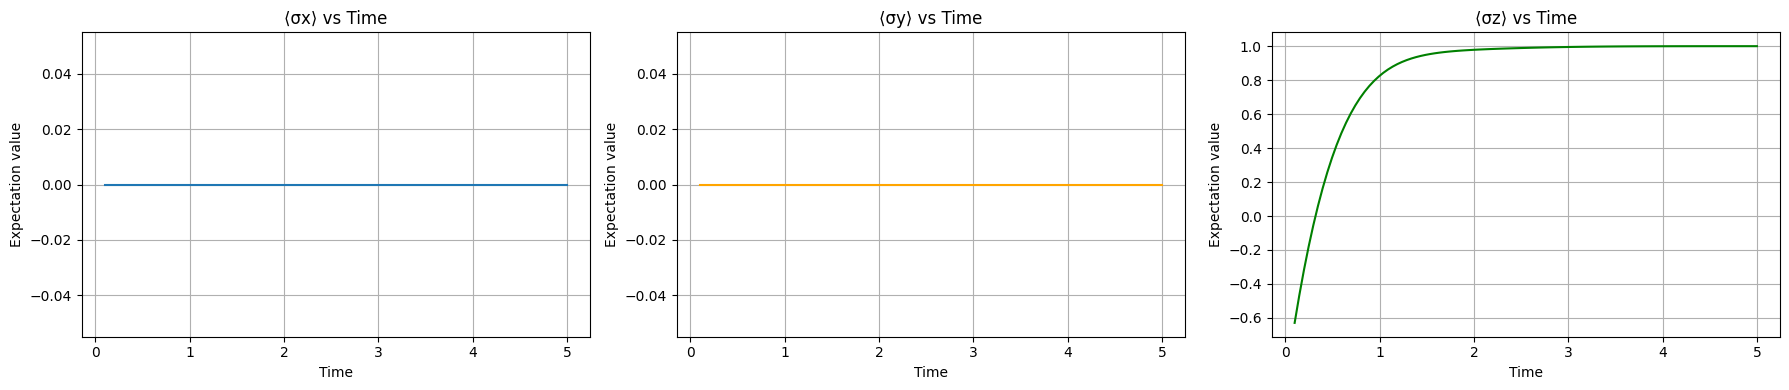

In [21]:
from qiskit.quantum_info import Pauli
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd
from scipy.linalg import expm
from numpy.linalg import eig
from qutip import Qobj, to_kraus

##############################################
from qutip import *

gamma = 2.0           # Decay rate
# for hamiltonian energy spliting
omega = 1.0          
sm = destroy(2)                   # σ-
sp = sm.dag()                     # σ+
Z = sigmaz()                      # Pauli Z
H = -0.5 * omega * Z          
c_ops = [np.sqrt(gamma) * sm]
L1 = liouvillian(H, c_ops)
##############################################
times = np.linspace(0.1, 5,100)
exp_vals_x = []
exp_vals_y = []
exp_vals_z = []


def super_to_choi(q_oper: Qobj) -> (Qobj, int, int):
# Extract raw array and dims
    data = q_oper.full()
    dims = q_oper.dims  
    d0 = dims[0][0][0] 
    d1 = dims[1][0][0] 
    # Build the Choi array 
    choi_arr = (
        data.reshape((d0, d1, d0, d1))
            .transpose(3, 1, 2, 0)
            .reshape((d0*d1, d0*d1))
    )

    choi = Qobj(choi_arr,
                dims=[[ [d1], [d0] ],   # row dims = [d_out, d_in]
                      [ [d1], [d0] ]],  # col dims = same for a square 4×4 matrix
                superrep='choi')
    return choi, d0, d1


def choi_to_kraus(choi: Qobj, d0: int, d1: int, tol: float = 1e-9) -> list[Qobj]:
    # Eigen decomposition of the Choi matrix
    vals, vecs = eig(choi.full())
    kraus_ops = []
    for val, vec in zip(vals, vecs.T):
        if val > tol:
            mat = vec.reshape((d1, d0), order='F')
           
            K = Qobj(np.sqrt(val) * mat,
                     dims=[[d1], [d0]])
            kraus_ops.append(K)
    return kraus_ops


def super_to_kraus(q_oper: Qobj, tol: float = 1e-9) -> list[Qobj]:

    choi, d0, d1 = super_to_choi(q_oper)
    return choi_to_kraus(choi, d0, d1, tol)

#SVD and walsh  
def SVD(Kraus_op):
    
    U_1, sigma_1, V_dagger = svd(Kraus_op)
    
    sigma_vals1 = sigma_1
    sigma1 = np.diag(sigma_1)
    f_k1 = np.zeros(4)
    for i, sigma_val in enumerate(sigma_vals1):
        val = float(np.clip(sigma_val, -1, 1))
        f_k1[i] = np.arccos(val)
        f_k1[i+2] = -np.arccos(val)
    # print(f_k1)
    W1 = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1], 
              [1, 1, -1, -1],
              [1, -1, -1, 1]])
    a1 = (W1 @ f_k1) / 4
    U_sigma = np.diag(np.exp(1j * np.array(f_k1)))
    # L = (U_1 @ sigma1 @ V_dagger)
    return U_1 , U_sigma , V_dagger

#############################################################
def Quantum_circuit(U, sigma,V):
    qc = QuantumCircuit(2)
    qc.x(0)

    V = UnitaryGate(V, label="Vgate")
    qc.append(V, [0])

    qc.h(1)

    U_sigma_gate = UnitaryGate(sigma, label="Usigma")
    qc.append(U_sigma_gate, [0, 1])

 
    U = UnitaryGate(U, label="Ugate")
    qc.append(U, [0])
    qc.h(1)

    qc.save_statevector()
    
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc,  shots=1024, memory=True).result()
    statevector = result.get_statevector(qc)
    # print("State vector:\n", statevector)   
    final_state =[]
    for i in range(2):
        final_state.append(statevector[i])

    final_state = np.array(final_state)
    rho0_t = np.outer(final_state, np.conj(final_state))
    # print("State vector:\n", np.round(rho0_t,8))
    qc.draw('mpl')
    return rho0_t
##############################################################


for t in times:
    # K0 , K1 = kraus_ops_(t)
    superprop = (t * L1).expm()
    kraus_ops = super_to_kraus(superprop)
 
    K0 = kraus_ops[0]
    K1 = kraus_ops[1]
    K0 = np.real(K0.full())
    K1 = np.real(K1.full())
    U1 , sigma1 , V1 = SVD(K1)
    U2 , sigma2 , V2 = SVD(K0)

    rho_0T = Quantum_circuit(U1,sigma1, V1)
    rho_1T = Quantum_circuit(U2,sigma2, V2)
    rho_final = np.round((rho_0T + rho_1T),8)

    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    exp_vals_x.append(np.round((np.real(np.trace(rho_final @ sigma_x))),8))
    exp_vals_y.append(np.round((np.real(np.trace(rho_final @ sigma_y))),8))
    exp_vals_z.append(np.real(np.trace(np.dot(rho_final, sigma_z))))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    
axes[0].plot(times,np.round(exp_vals_x,8), label="⟨σx⟩")
axes[0].set_title("⟨σx⟩ vs Time")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Expectation value")
axes[0].grid(True)

axes[1].plot(times, exp_vals_y, label="⟨σy⟩", color='orange')
axes[1].set_title("⟨σy⟩ vs Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Expectation value")
axes[1].grid(True)

axes[2].plot(times, exp_vals_z, label="⟨σz⟩", color='green')
axes[2].set_title("⟨σz⟩ vs Time")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Expectation value")
axes[2].grid(True)

plt.tight_layout()
plt.show()


# Implementation of The Equation Simulation in IBM Qiskit Primitives 

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Initialize the service 
service = QiskitRuntimeService()
print(service)
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")



<QiskitRuntimeService>
Using backend: ibm_torino


Job ID: d22ctqs7tigc7395b5sg
Expectation values: [ 1.00000000e+00 -5.58190539e-16  5.81820470e-02  9.67159876e-01
  4.91250937e-05 -4.04213624e-03  1.27086927e-01  1.33129817e-02
  9.60777366e-02  2.86014121e-02 -4.16372731e-03  3.31382510e-02
  8.74898033e-01 -4.39466201e-02 -1.76266579e-03  1.10620696e+00]
Job ID: d22cu847tigc7395b6a0
Expectation values: [ 1.00000000e+00 -2.13784654e-02  1.03852795e-03 -9.83952730e-01
  1.50634567e-03  8.51502826e-02  1.51261377e-02 -1.72927091e-02
  3.87530784e-02 -6.24110162e-03 -2.00806857e-02 -1.41343923e-02
 -8.63195092e-01  5.64886790e-16  3.33757559e-02  1.07619427e+00]
[[ 9.87066218e-01+0.j         -1.09866550e-02-0.01410485j
   3.34052671e-03-0.032304j    3.03977654e-05-0.03892208j]
 [-1.09866550e-02+0.01410485j -4.96172018e-02+0.j
  -2.05146589e-03+0.02462138j -3.31596416e-03-0.01573487j]
 [ 3.34052671e-03+0.032304j   -2.05146589e-03-0.02462138j
  -3.48628012e-03+0.j          1.09866550e-02-0.01498618j]
 [ 3.03977654e-05+0.03892208j -3.3159

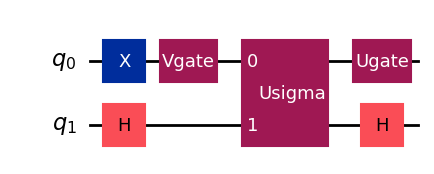

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np

def Quantum_circuit(U, sigma, V):
    qc = QuantumCircuit(2)
    qc.x(0)

    V_gate = UnitaryGate(V, label="Vgate")
    qc.append(V_gate, [0])

    qc.h(1)

    U_sigma_gate = UnitaryGate(sigma, label="Usigma")
    qc.append(U_sigma_gate, [0, 1])

    U_gate = UnitaryGate(U, label="Ugate")
    qc.append(U_gate, [0])
    qc.h(1)

    # Transpile circuit for hardware optimization
    qc_opt = transpile(qc, backend=backend, optimization_level=1)

    # Define complete Pauli basis 
    pauli_strings = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 
                     'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

    pauli_observables = [SparsePauliOp.from_list([(p, 1.0)]) for p in pauli_strings]

    # Apply layout consistency between circuit and observables
    pauli_observables = [obs.apply_layout(qc_opt.layout) for obs in pauli_observables]

    
    estimator = Estimator(backend)
    estimator.options.resilience_level = 2
    
    job = estimator.run([(qc_opt, pauli_observables)])
    print(f"Job ID: {job.job_id()}")
    
    result = job.result()
    expectation_values = result[0].data.evs
    print("Expectation values:", expectation_values)
    
    # Reconstruct density matrix from Pauli expectation values
    def density_matrix(expectation_values, pauli_strings):
        pauli_matrices = {
            'I': np.array([[1, 0], [0, 1]]),
            'X': np.array([[0, 1], [1, 0]]),
            'Y': np.array([[0, -1j], [1j, 0]]),
            'Z': np.array([[1, 0], [0, -1]])
        }

        rho = np.zeros((4, 4), dtype=complex)

        for i, pauli_str in enumerate(pauli_strings):
            # Construct 2-qubit Pauli operator via tensor product
            pauli_op = pauli_matrices[pauli_str[0]]
            pauli_op = np.kron(pauli_op, pauli_matrices[pauli_str[1]])
            
            rho += expectation_values[i] * pauli_op / 4

        return rho

    rho = density_matrix(expectation_values, pauli_strings)
    
    return rho , qc

rho_0T , qc = Quantum_circuit(U1,sigma1, V1)
rho_1T , qc  = Quantum_circuit(U2,sigma2, V2)
print( rho_0T, rho_1T)
Rho = rho_0T + rho_1T

#########################################
def kraus_ops_(t):
    lambda_t = 1 - np.exp((-gamma*t))
    K0 = np.array([[1, 0], [0, np.sqrt(1 - lambda_t)]])
    K1 = np.array([[0, np.sqrt(lambda_t)], [0, 0]])
    return K0, K1
gamma = 1.0
t=5
K0 , K1 = kraus_ops_(t)
rho = np. array([[0,0],[0,1]]) # state rho(0) = |1> <1|

rho_t = (K0 @ rho @ K0.conj().T ) + (K1 @ rho @ K1.conj().T)
print(f"Initial state ", rho)
print(f"Final analytical state: ")
print(np.round(rho_t, 4))
###############################################
print("Quantum Simulation result :\n", np.real(np.round((Rho[:2, :2]),3)))
qc.draw('mpl')